In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12.0,12.0]
%matplotlib inline

from keras import backend as K
from keras import utils
from keras.utils.training_utils import multi_gpu_model
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import mobilenetv2
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

from coremdlr.utils import facies_utils, models_utils

Using TensorFlow backend.


In [4]:
SAVE_DIR = '/home/administrator/Dropbox/core_data/saved_models/mobilenet/'

IMG = '/home/administrator/Dropbox/core_data/facies/Columns/CoreLab_FULL_image.npy'
LABELS = '/home/administrator/Dropbox/core_data/facies/Columns/CoreLab_FULL_facies.npy'

In [5]:
img = np.load(IMG)
class_labels = np.load(LABELS)
n_classes = 9
metrics=['accuracy']

X, y = facies_utils.make_labeled_frames(img[:,152:248], 
                                        class_labels, 
                                        96, stride=96)

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=27,
                                                  stratify=y)

class_weights = class_weight.compute_class_weight('balanced', np.unique(y), y)

Making  6327  patches...
Label counts =  [(1, 418), (2, 322), (3, 285), (4, 2150), (5, 2057), (6, 250), (7, 664), (8, 90), (9, 91)]


In [6]:
y_train = utils.to_categorical(y_train, n_classes)
y_val = utils.to_categorical(y_val, n_classes)

print('Training label counts: ', np.sum(y_train, axis=0))
print('Validate label counts: ', np.sum(y_val, axis=0))

Training label counts:  [ 334.  258.  228. 1720. 1645.  200.  531.   72.   73.]
Validate label counts:  [ 84.  64.  57. 430. 412.  50. 133.  18.  18.]


In [7]:
train_gen = ImageDataGenerator(width_shift_range=0.1,
                               shear_range=-5.0,
                               zoom_range=0.05,
                               fill_mode='constant', cval=0.0,
                               horizontal_flip=True)
val_gen = ImageDataGenerator()

train_gen.fit(X_train)
val_gen.fit(X_val)

In [8]:
# Build Model
mnet_base = mobilenetv2.MobileNetV2(include_top=False, weights='imagenet',
                                    input_shape=(96,96,3))
mnet_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (Activation)         (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
__________________________________________________________________________________________________
expanded_c

In [23]:
x = mnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=mnet_base.input, outputs=predictions)

# first train new top layers
for layer in mnet_base.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=metrics)

print("CURRENT TRAINABLE LAYERS:")
models_utils.print_layers(model, only_trainable=True)

CURRENT TRAINABLE LAYERS:
150 global_average_pooling2d_4 True
151 dense_7 True
152 dense_8 True


In [24]:
epochs = 500
batch_size = 64
early_stop = EarlyStopping(monitor='val_loss', patience=25)

train_flow = train_gen.flow(X_train, y_train, batch_size=batch_size)
val_flow = val_gen.flow(X_val, y_val, batch_size=batch_size)

history_1 = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train)/batch_size,
                    #class_weight = class_weights,
                    validation_data=val_flow,
                    validation_steps=len(X_val)/batch_size,
                    callbacks=[early_stop], verbose=1, epochs=epochs)

with open('./training_logs/mNet_classes_ColorInput', 'wb') as hist_pickle:
        pickle.dump(history_1.history, hist_pickle)

models_utils.save_keras_model(model, SAVE_DIR+'mNet_classes_ColorInput')

Epoch 1/500
80/79 [==============================] - 8s 105ms/step - loss: 0.5350 - acc: 0.8311 - val_loss: 6.6119 - val_acc: 0.3223
Epoch 2/500
80/79 [==============================] - 7s 84ms/step - loss: 0.3934 - acc: 0.8669 - val_loss: 6.4185 - val_acc: 0.3436
Epoch 3/500
80/79 [==============================] - 7s 91ms/step - loss: 0.3561 - acc: 0.8726 - val_loss: 6.9309 - val_acc: 0.3673
Epoch 4/500
80/79 [==============================] - 7s 90ms/step - loss: 0.3619 - acc: 0.8660 - val_loss: 6.9051 - val_acc: 0.3689
Epoch 5/500
80/79 [==============================] - 7s 90ms/step - loss: 0.3362 - acc: 0.8771 - val_loss: 7.2552 - val_acc: 0.2828
Epoch 6/500
80/79 [==============================] - 7s 91ms/step - loss: 0.3225 - acc: 0.8846 - val_loss: 7.0653 - val_acc: 0.3586
Epoch 7/500
80/79 [==============================] - 7s 90ms/step - loss: 0.3151 - acc: 0.8886 - val_loss: 6.5706 - val_acc: 0.3728
Epoch 8/500
80/79 [==============================] - 7s 90ms/step - loss: 0

In [25]:
# Now train whole network
for layer in model.layers:
    layer.trainable = True

model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=metrics)

print("CURRENT TRAINABLE LAYERS:")
models_utils.print_layers(model, only_trainable=True)

CURRENT TRAINABLE LAYERS:
0 input_1 True
1 Conv1 True
2 bn_Conv1 True
3 Conv1_relu True
4 expanded_conv_depthwise True
5 expanded_conv_depthwise_BN True
6 expanded_conv_depthwise_relu True
7 expanded_conv_project True
8 expanded_conv_project_BN True
9 block_1_expand True
10 block_1_expand_BN True
11 block_1_expand_relu True
12 block_1_depthwise True
13 block_1_depthwise_BN True
14 block_1_depthwise_relu True
15 block_1_project True
16 block_1_project_BN True
17 block_2_expand True
18 block_2_expand_BN True
19 block_2_expand_relu True
20 block_2_depthwise True
21 block_2_depthwise_BN True
22 block_2_depthwise_relu True
23 block_2_project True
24 block_2_project_BN True
25 block_2_add True
26 block_3_expand True
27 block_3_expand_BN True
28 block_3_expand_relu True
29 block_3_depthwise True
30 block_3_depthwise_BN True
31 block_3_depthwise_relu True
32 block_3_project True
33 block_3_project_BN True
34 block_4_expand True
35 block_4_expand_BN True
36 block_4_expand_relu True
37 block_4_d

In [26]:
epochs = 500
batch_size = 64 
early_stop = EarlyStopping(monitor='val_loss', patience=25)

history_2 = model.fit_generator(train_flow,
                    steps_per_epoch=len(X_train)/batch_size,
                    class_weight = class_weights,
                    validation_data=val_flow,
                    validation_steps=len(X_val)/batch_size,
                    callbacks=[early_stop], verbose=1, epochs=epochs)

with open('./training_logs/mNet_full_ColorInput', 'wb') as hist_pickle:
        pickle.dump(history_2.history, hist_pickle)
        
models_utils.save_keras_model(model, SAVE_DIR+'mNet_full_ColorInput')

Epoch 1/500
80/79 [==============================] - 14s 180ms/step - loss: 0.5442 - acc: 0.8168 - val_loss: 5.9767 - val_acc: 0.3791
Epoch 2/500
80/79 [==============================] - 8s 105ms/step - loss: 0.4456 - acc: 0.8437 - val_loss: 9.0394 - val_acc: 0.3712
Epoch 3/500
80/79 [==============================] - 8s 103ms/step - loss: 0.4279 - acc: 0.8422 - val_loss: 8.1591 - val_acc: 0.3333
Epoch 4/500
80/79 [==============================] - 8s 104ms/step - loss: 0.3900 - acc: 0.8644 - val_loss: 7.4934 - val_acc: 0.3760
Epoch 5/500
80/79 [==============================] - 8s 103ms/step - loss: 0.4098 - acc: 0.8612 - val_loss: 6.8028 - val_acc: 0.4210
Epoch 6/500
80/79 [==============================] - 8s 103ms/step - loss: 0.3966 - acc: 0.8590 - val_loss: 6.0281 - val_acc: 0.4329
Epoch 7/500
80/79 [==============================] - 8s 104ms/step - loss: 0.3574 - acc: 0.8760 - val_loss: 6.2589 - val_acc: 0.3333
Epoch 8/500
80/79 [==============================] - 8s 104ms/step -

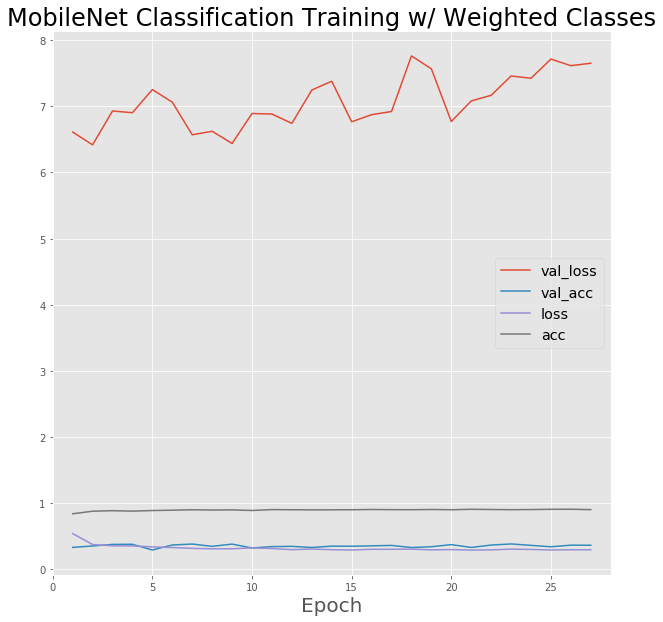

In [27]:
plt.show(models_utils.make_training_fig(history_1.history,
                      title="MobileNet Classification Training w/ Weighted Classes"))

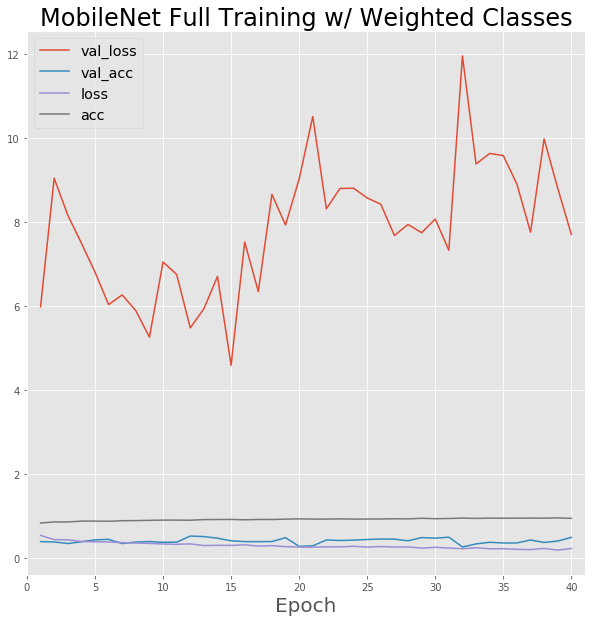

In [28]:
plt.show(models_utils.make_training_fig(history_2.history,
                      title="MobileNet Full Training w/ Weighted Classes"))

In [29]:
y_hat = model.predict_generator(val_gen.flow(X_val))
y_hat = np.argmax(y_hat, axis=1)

y_true = np.argmax(y_val, axis=1)

In [30]:
facies_names = ['argilaceous siltstone', 'fossiliferous argilaceous siltstone',
     'siliceous mudstone', 'argilaceous siliceous mudstone', 'calcareous siliceous mudstone',
     'wackestone', 'packstone - grainstone', 'rudstone', 'dolomitic packstone']

cnf_matrix = confusion_matrix(y_true+1, y_hat+1)

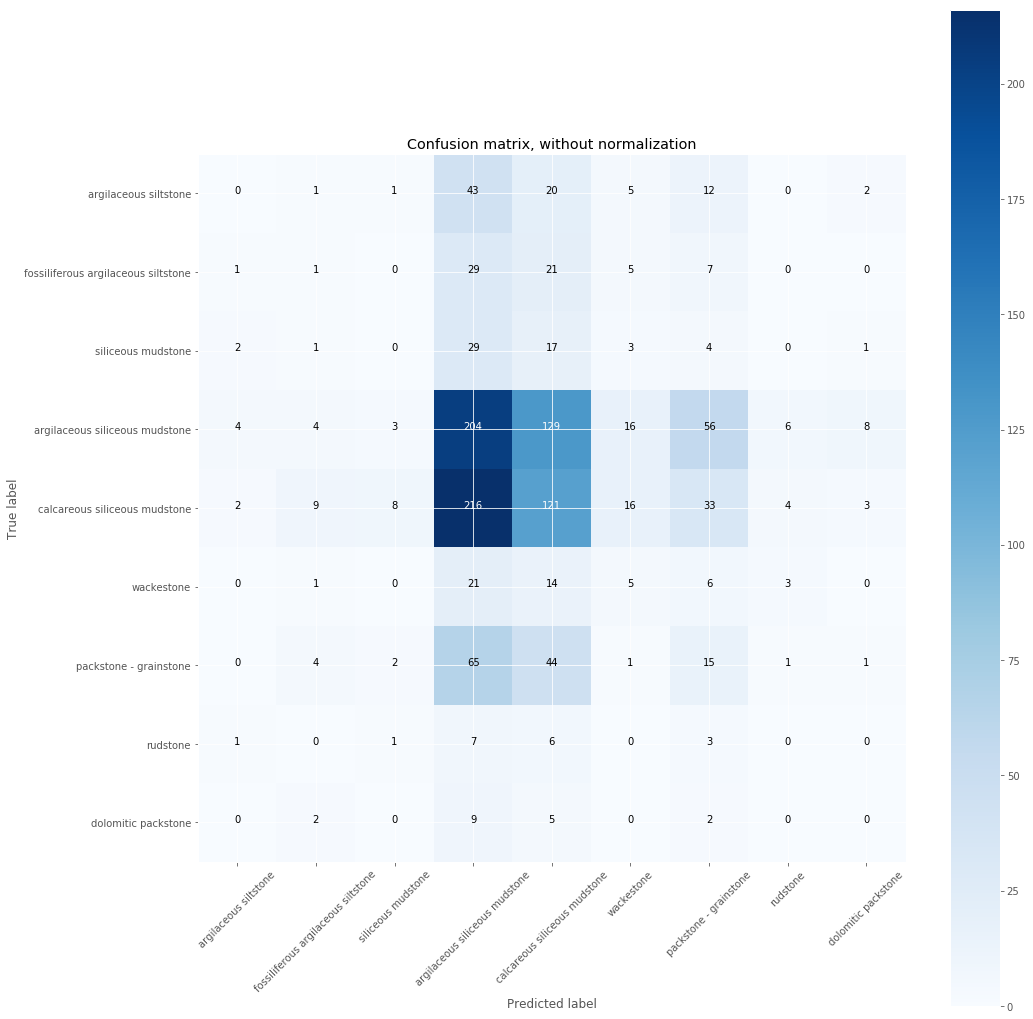

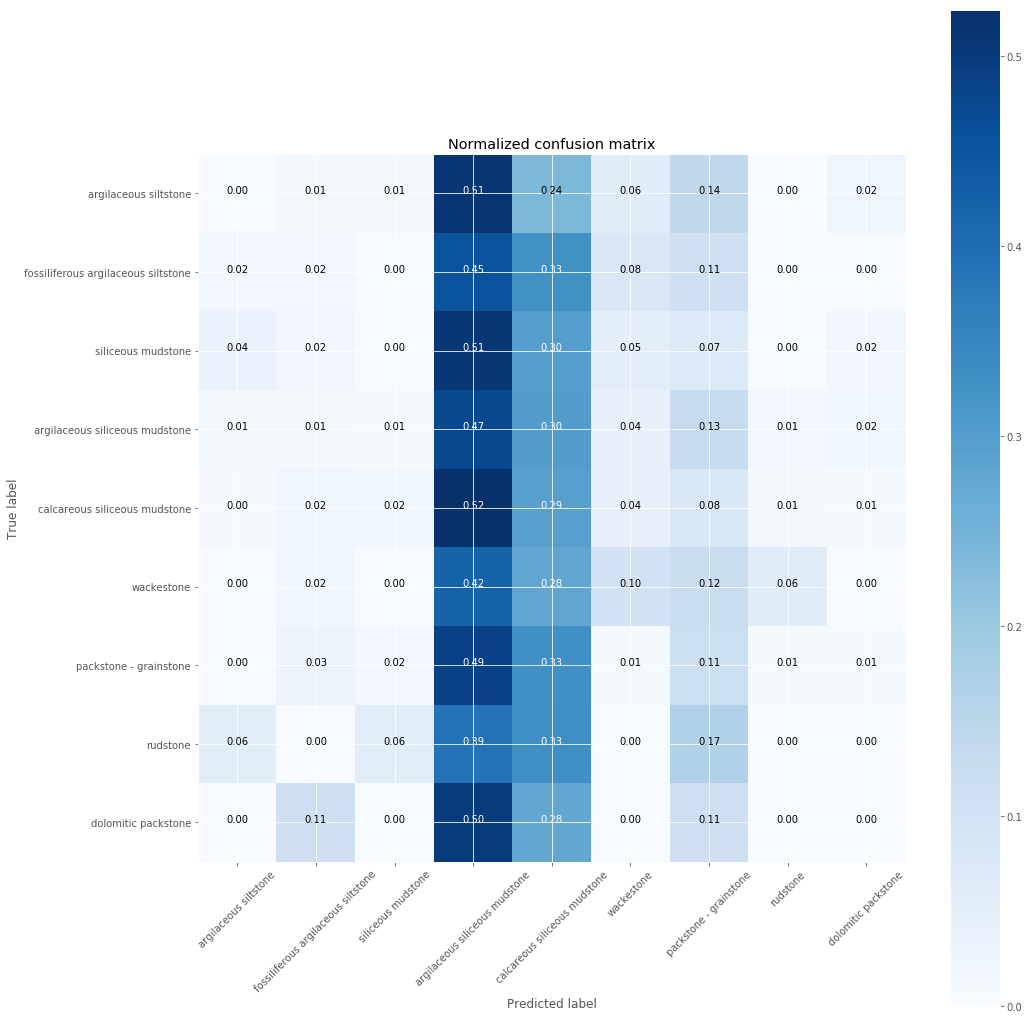

In [31]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(15,15))
models_utils.make_confusion_fig(cnf_matrix, classes=facies_names,
                      title='Confusion matrix, without normalization')
plt.show()

# Plot normalized confusion matrix
plt.figure(figsize=(15,15))
models_utils.make_confusion_fig(cnf_matrix, classes=facies_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [21]:
# Print Validation Accuracy
sum(np.equal(y_true, y_hat)) / y_hat.size

0.2527646129541864

In [33]:
dir(history_1)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'epoch',
 'history',
 'model',
 'on_batch_begin',
 'on_batch_end',
 'on_epoch_begin',
 'on_epoch_end',
 'on_train_begin',
 'on_train_end',
 'params',
 'set_model',
 'set_params',
 'validation_data']

In [39]:
type(history_1)

keras.callbacks.History

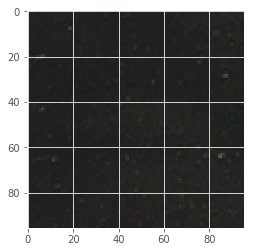

In [64]:
test = X_val[5,...]
plt.imshow(test)

input_1


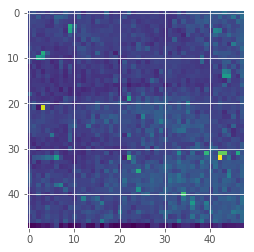

Conv1


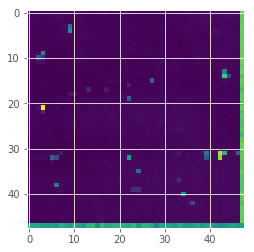

bn_Conv1


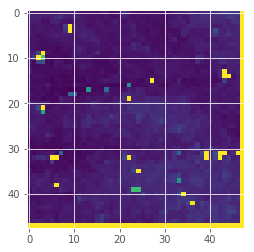

Conv1_relu


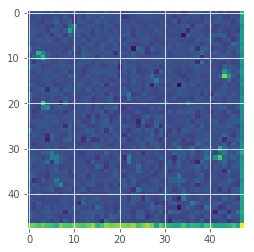

expanded_conv_depthwise


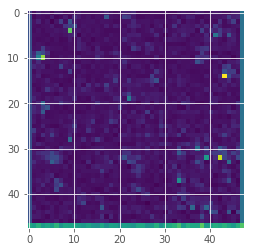

expanded_conv_depthwise_BN


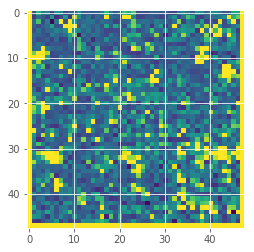

expanded_conv_depthwise_relu


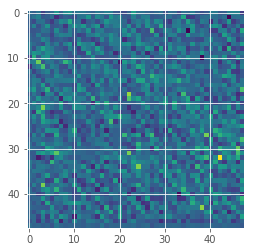

expanded_conv_project


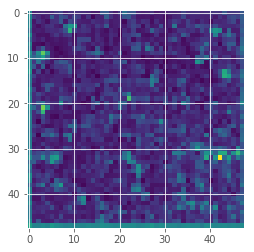

expanded_conv_project_BN


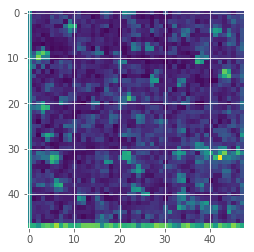

block_1_expand


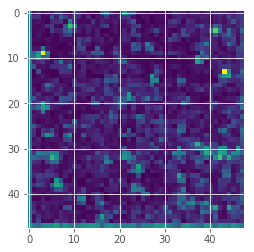

block_1_expand_BN


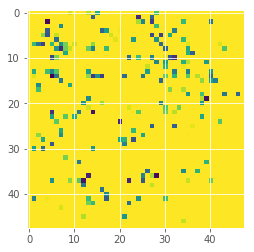

block_1_expand_relu


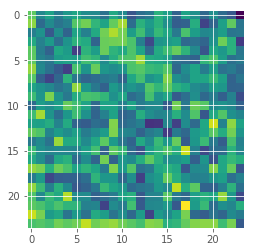

block_1_depthwise


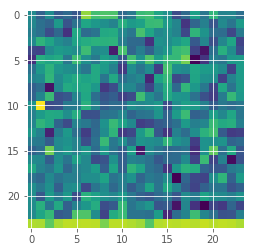

block_1_depthwise_BN


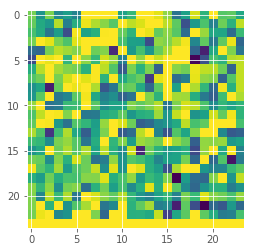

block_1_depthwise_relu


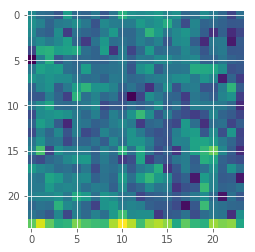

block_1_project


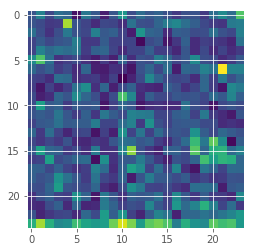

block_1_project_BN


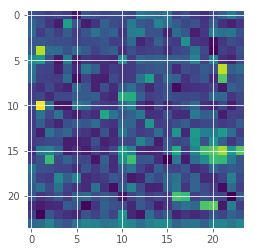

block_2_expand


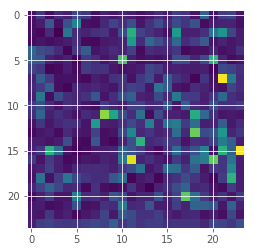

block_2_expand_BN


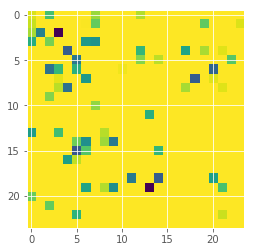

block_2_expand_relu


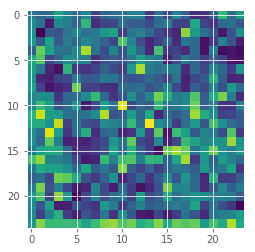

block_2_depthwise


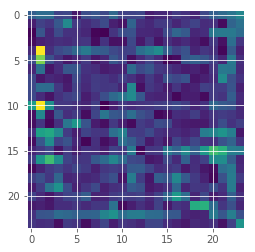

block_2_depthwise_BN


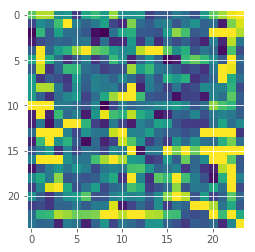

block_2_depthwise_relu


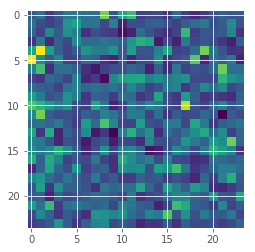

block_2_project


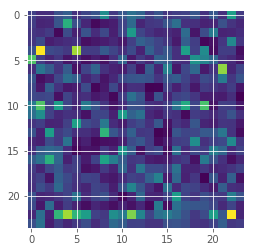

block_2_project_BN


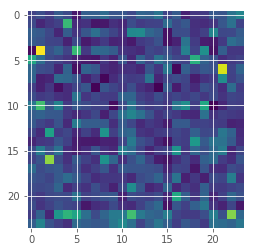

block_2_add


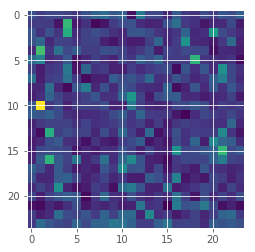

block_3_expand


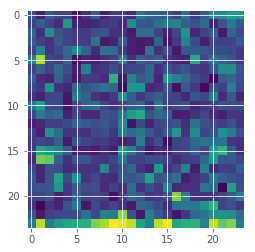

block_3_expand_BN


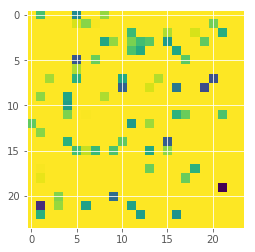

block_3_expand_relu


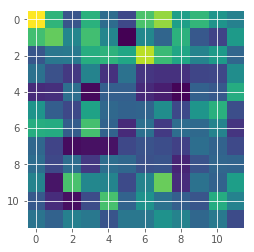

block_3_depthwise


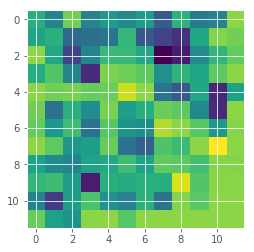

block_3_depthwise_BN


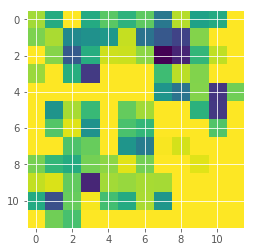

block_3_depthwise_relu


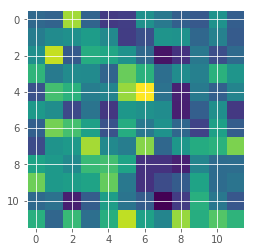

block_3_project


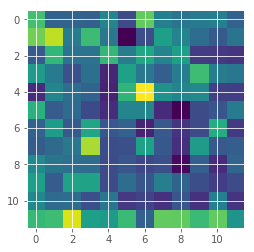

block_3_project_BN


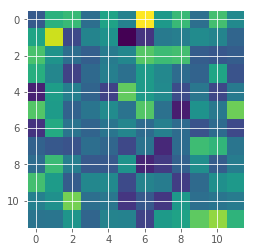

block_4_expand


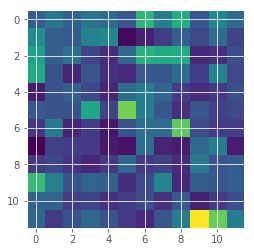

block_4_expand_BN


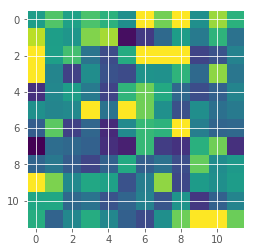

block_4_expand_relu


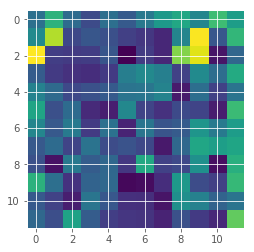

block_4_depthwise


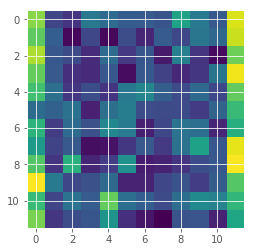

block_4_depthwise_BN


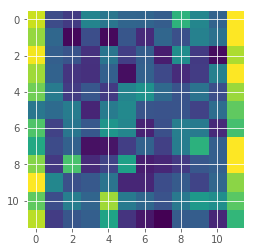

block_4_depthwise_relu


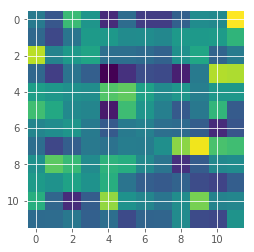

block_4_project


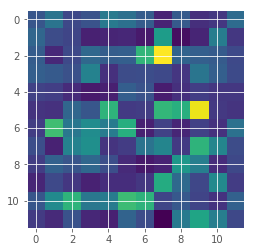

block_4_project_BN


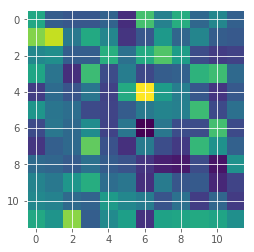

block_4_add


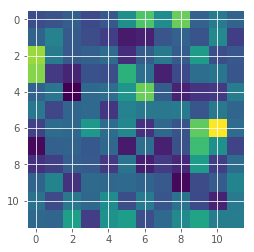

block_5_expand


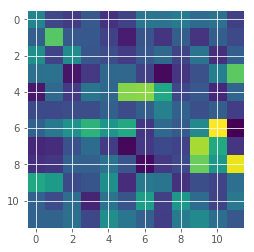

block_5_expand_BN


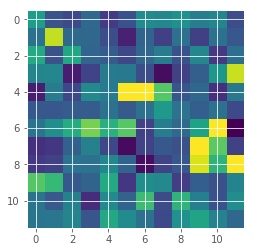

block_5_expand_relu


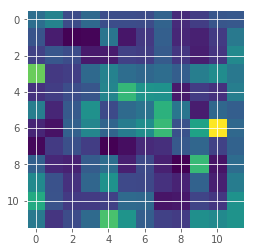

block_5_depthwise


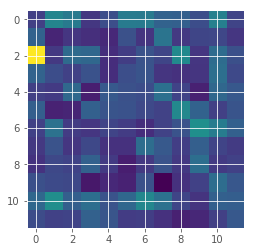

block_5_depthwise_BN


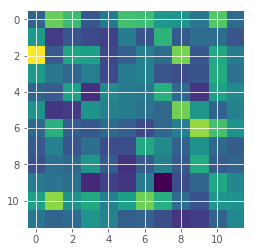

block_5_depthwise_relu


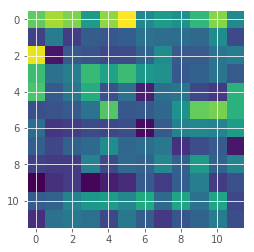

block_5_project


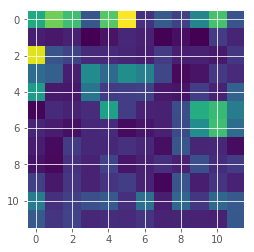

block_5_project_BN


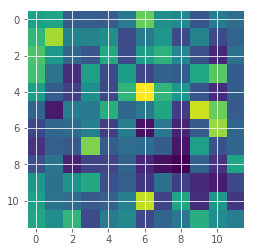

block_5_add


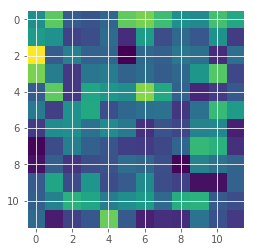

block_6_expand


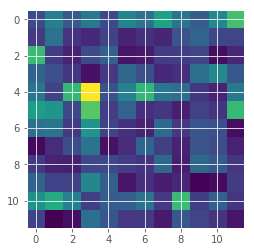

block_6_expand_BN


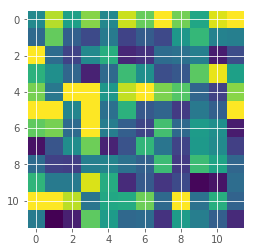

block_6_expand_relu


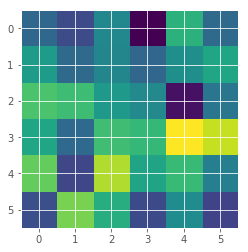

block_6_depthwise


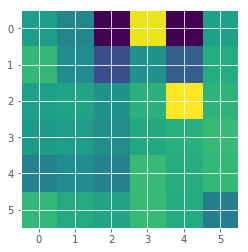

block_6_depthwise_BN


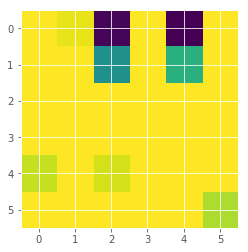

block_6_depthwise_relu


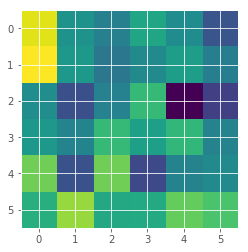

block_6_project


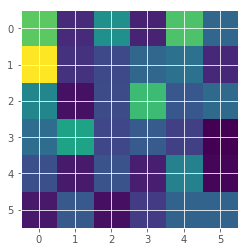

block_6_project_BN


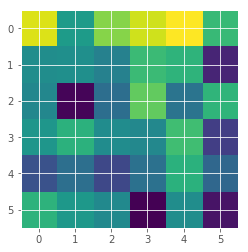

block_7_expand


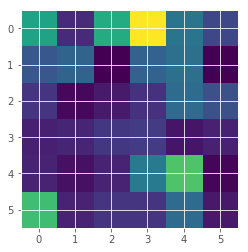

block_7_expand_BN


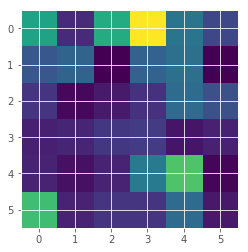

block_7_expand_relu


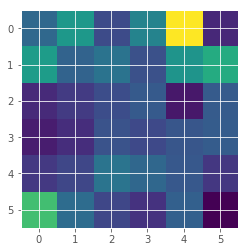

block_7_depthwise


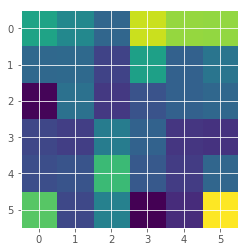

block_7_depthwise_BN


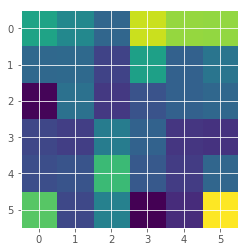

block_7_depthwise_relu


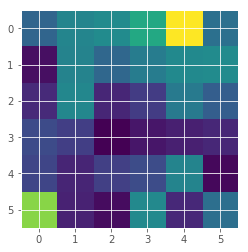

block_7_project


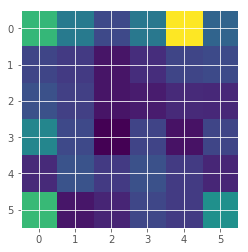

block_7_project_BN


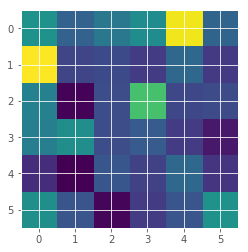

block_7_add


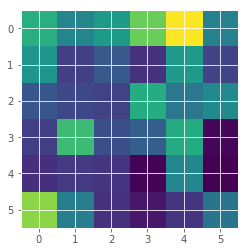

block_8_expand


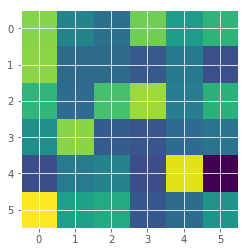

block_8_expand_BN


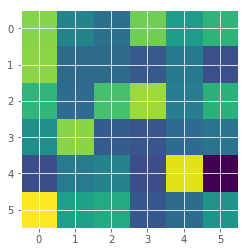

block_8_expand_relu


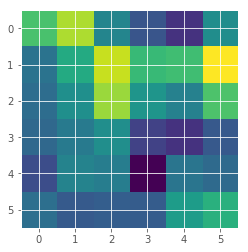

block_8_depthwise


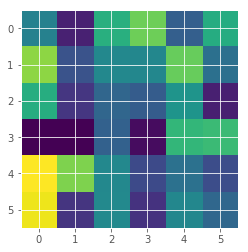

block_8_depthwise_BN


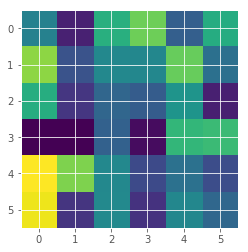

block_8_depthwise_relu


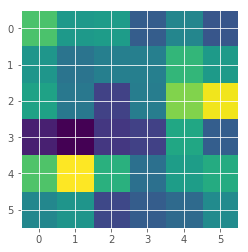

block_8_project


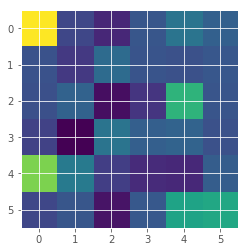

block_8_project_BN


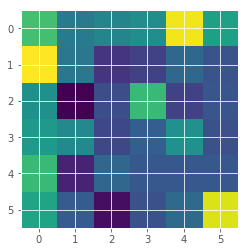

block_8_add


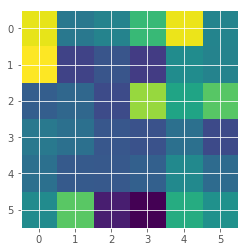

block_9_expand


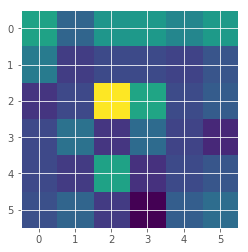

block_9_expand_BN


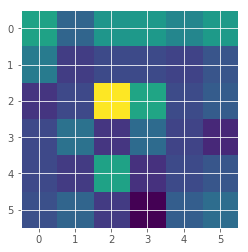

block_9_expand_relu


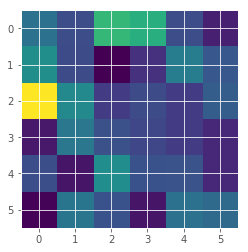

block_9_depthwise


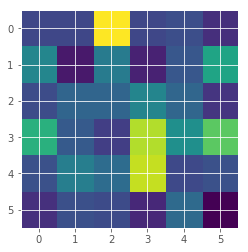

block_9_depthwise_BN


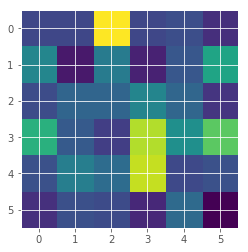

block_9_depthwise_relu


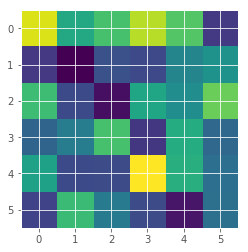

block_9_project


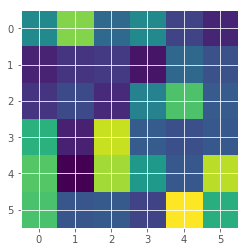

block_9_project_BN


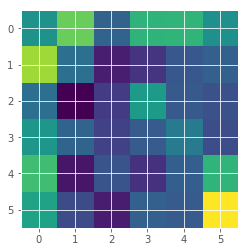

block_9_add


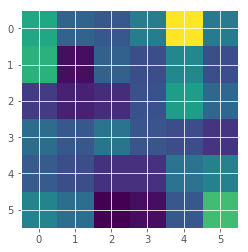

block_10_expand


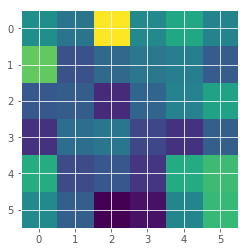

block_10_expand_BN


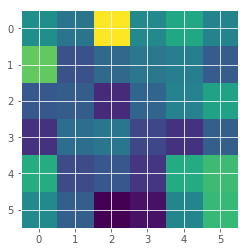

block_10_expand_relu


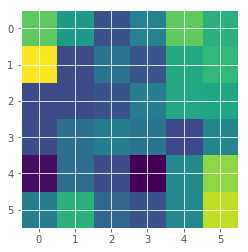

block_10_depthwise


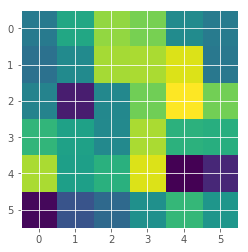

block_10_depthwise_BN


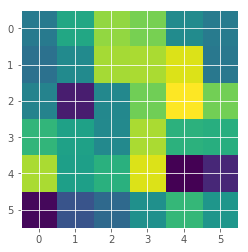

block_10_depthwise_relu


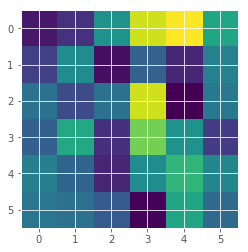

block_10_project


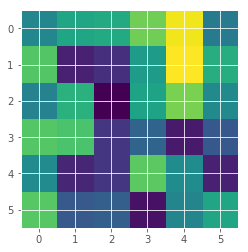

block_10_project_BN


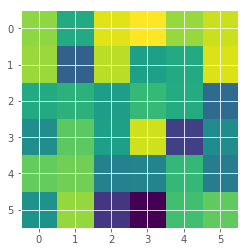

block_11_expand


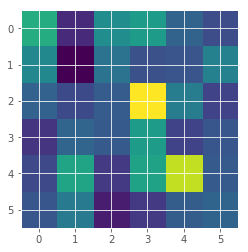

block_11_expand_BN


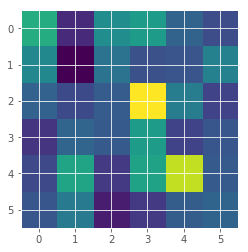

block_11_expand_relu


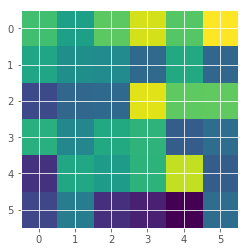

block_11_depthwise


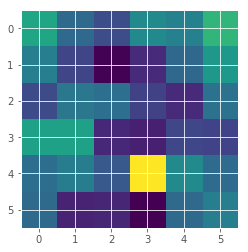

block_11_depthwise_BN


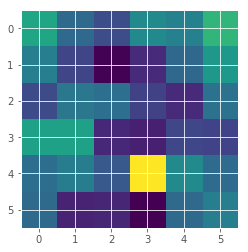

block_11_depthwise_relu


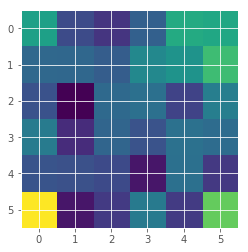

block_11_project


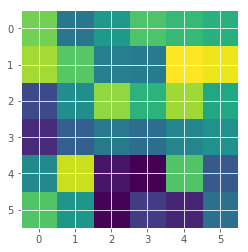

block_11_project_BN


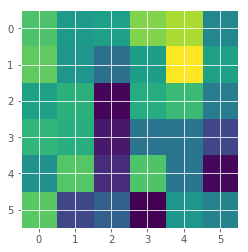

block_11_add


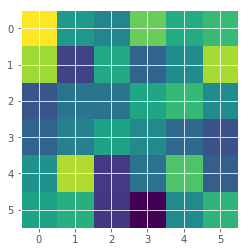

block_12_expand


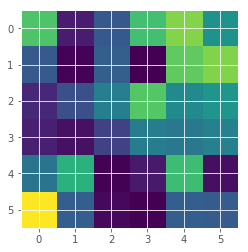

block_12_expand_BN


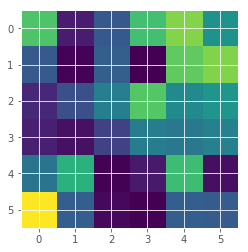

block_12_expand_relu


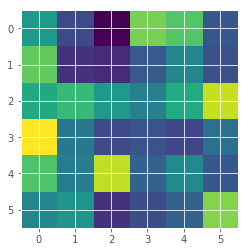

block_12_depthwise


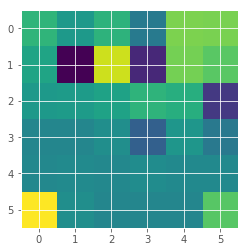

block_12_depthwise_BN


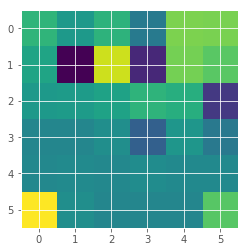

block_12_depthwise_relu


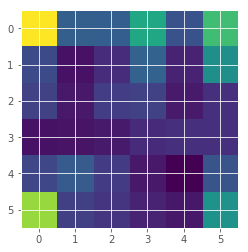

block_12_project


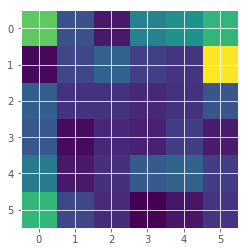

block_12_project_BN


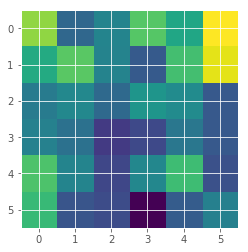

block_12_add


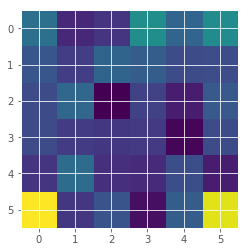

block_13_expand


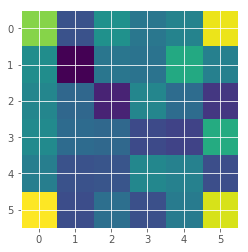

block_13_expand_BN


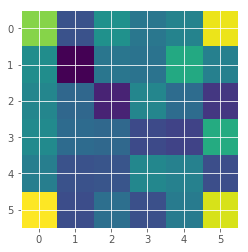

block_13_expand_relu


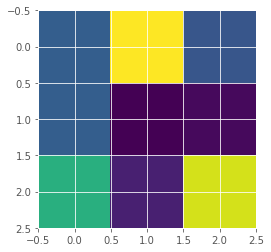

block_13_depthwise


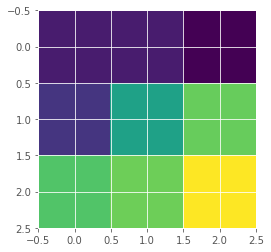

block_13_depthwise_BN


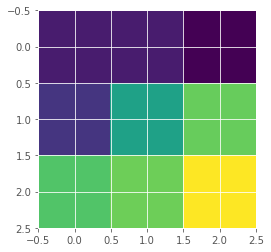

block_13_depthwise_relu


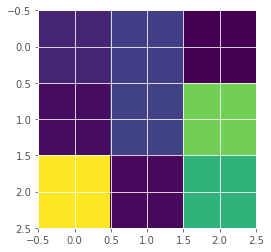

block_13_project


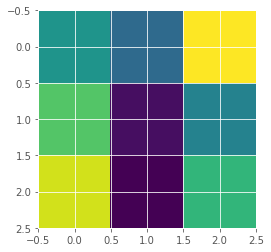

block_13_project_BN


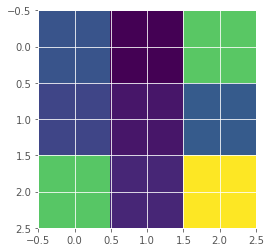

block_14_expand


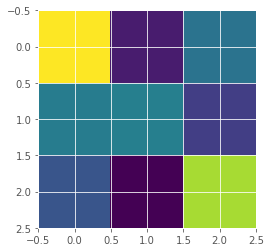

block_14_expand_BN


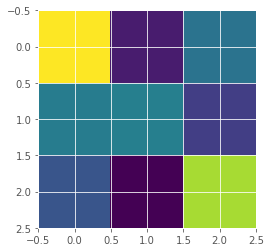

block_14_expand_relu


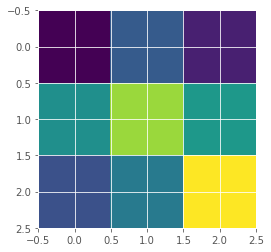

block_14_depthwise


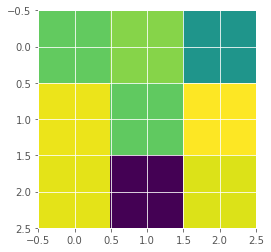

block_14_depthwise_BN


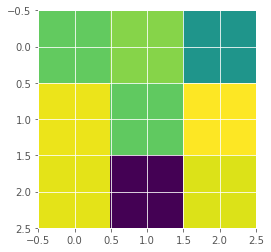

block_14_depthwise_relu


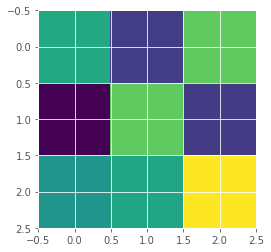

block_14_project


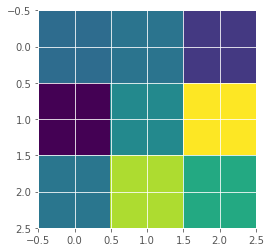

block_14_project_BN


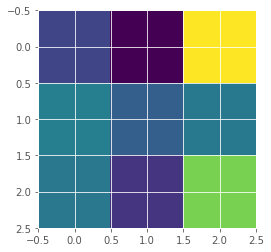

block_14_add


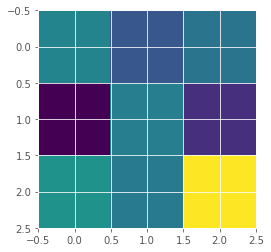

block_15_expand


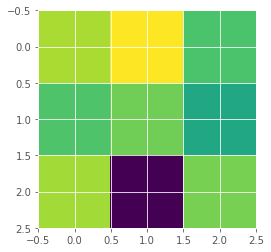

block_15_expand_BN


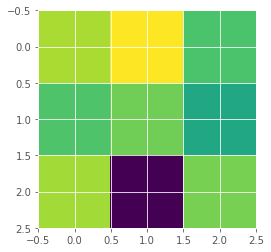

block_15_expand_relu


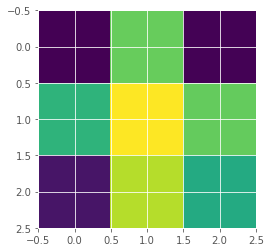

block_15_depthwise


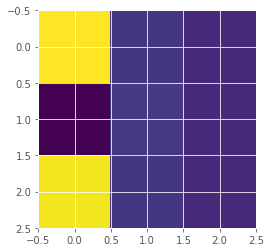

block_15_depthwise_BN


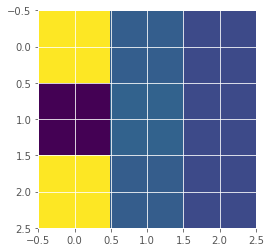

block_15_depthwise_relu


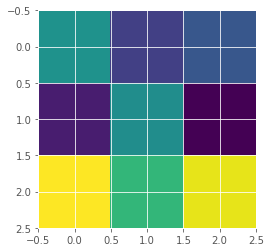

block_15_project


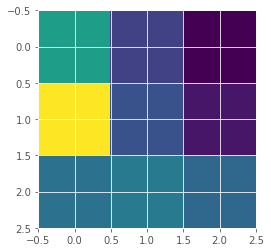

block_15_project_BN


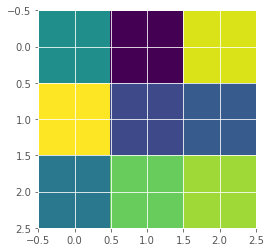

block_15_add


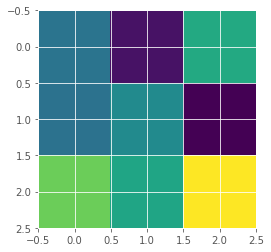

block_16_expand


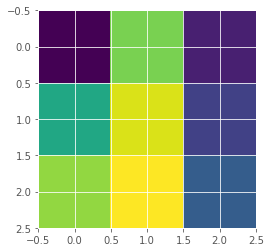

block_16_expand_BN


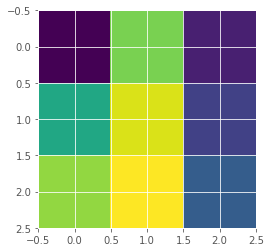

block_16_expand_relu


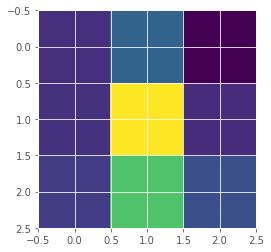

block_16_depthwise


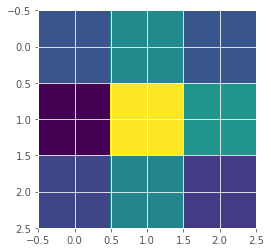

block_16_depthwise_BN


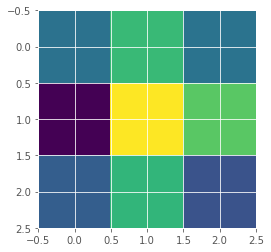

block_16_depthwise_relu


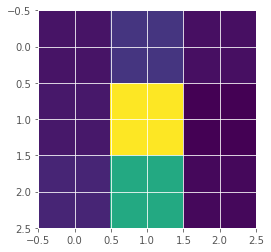

block_16_project


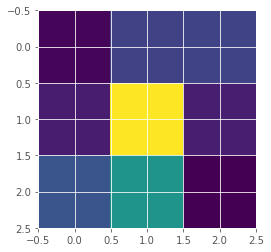

block_16_project_BN


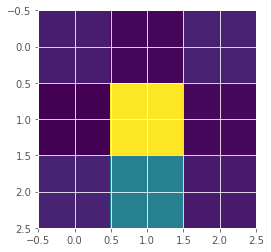

Conv_1


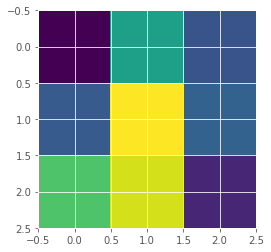

Conv_1_bn


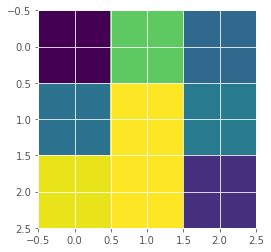

In [65]:
test = X_val[5,...]
plt.imshow(test)

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers[1:-3]]          # all layer outputs
functor = K.function([inp]+ [K.learning_phase()], outputs ) # evaluation function

# Testing
test = test[np.newaxis,...]
layer_outs = functor([test, 1.])
for i, out in enumerate(layer_outs):
    print(model.layers[i].name)
    ix_filter = np.random.randint(0, out.shape[-1])
    plt.imshow(np.max(out[0,...], axis=-1))
    plt.show()

TensorShape([Dimension(None), Dimension(96), Dimension(96), Dimension(3)])